In [ ]:
!pip install torch torchvision torchaudio -q
!pip install matplotlib opencv-python -q
!pip install albumentations -q


In [ ]:
import torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet

root_dir = './data'

# Load the dataset
dataset = OxfordIIITPet(root=root_dir, download=True, target_types='segmentation')


100%|██████████| 792M/792M [00:08<00:00, 93.4MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 69.3MB/s]


In [ ]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PetSegmentationDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, mask = self.dataset[idx]
        img = np.array(img)
        mask = np.array(mask)

        # Make mask binary: 1 = pet, 0 = background
        mask = np.where(mask == 1, 1, 0).astype('float32')

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
        return img, mask

transform = A.Compose([
    A.Resize(128, 128),
    A.Normalize(),
    ToTensorV2()
])

dataset = PetSegmentationDataset(dataset, transform=transform)

from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.down1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(128, 256)

        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.upconv1 = conv_block(256, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.upconv2 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        b = self.bottleneck(self.pool2(d2))

        u1 = self.up1(b)
        u1 = torch.cat([u1, d2], dim=1)
        u1 = self.upconv1(u1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d1], dim=1)
        u2 = self.upconv2(u2)

        return torch.sigmoid(self.final(u2))


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

def train_epoch(model, dataloader):
    model.train()
    total_loss = 0
    for img, mask in dataloader:
        img, mask = img.to(device), mask.to(device).unsqueeze(1)
        out = model(img)
        loss = loss_fn(out, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for img, mask in dataloader:
            img, mask = img.to(device), mask.to(device).unsqueeze(1)
            out = model(img)
            loss = loss_fn(out, mask)
            total_loss += loss.item()
    return total_loss / len(dataloader)

for epoch in range(10):
    train_loss = train_epoch(model, train_loader)
    val_loss = evaluate(model, val_loader)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch 1 | Train Loss: 0.5440 | Val Loss: 0.4856
Epoch 2 | Train Loss: 0.4646 | Val Loss: 0.4692
Epoch 3 | Train Loss: 0.4341 | Val Loss: 0.3996
Epoch 4 | Train Loss: 0.3915 | Val Loss: 0.3751
Epoch 5 | Train Loss: 0.3577 | Val Loss: 0.3384
Epoch 6 | Train Loss: 0.3370 | Val Loss: 0.3187
Epoch 7 | Train Loss: 0.3098 | Val Loss: 0.3071
Epoch 8 | Train Loss: 0.3000 | Val Loss: 0.2915
Epoch 9 | Train Loss: 0.2815 | Val Loss: 0.2930
Epoch 10 | Train Loss: 0.2795 | Val Loss: 0.3002


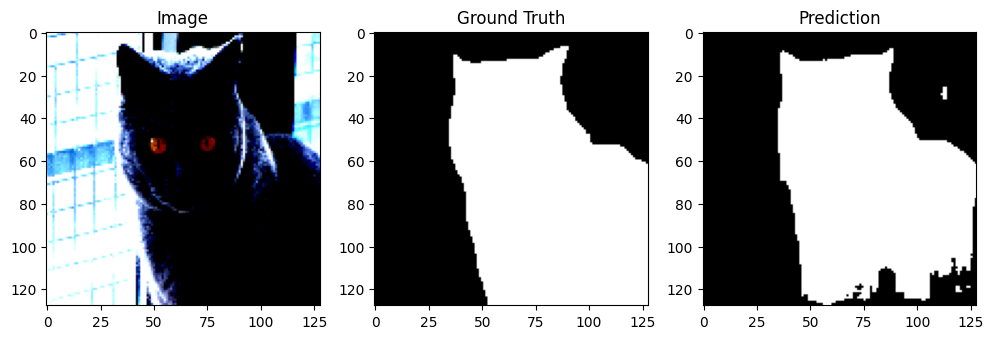

In [ ]:
import matplotlib.pyplot as plt

def show_prediction(model, dataset, index=0):
    model.eval()
    img, mask = dataset[index]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))[0]
    pred = pred.squeeze().cpu().numpy()
    img = img.permute(1, 2, 0).numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Image")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground Truth")

    plt.subplot(1, 3, 3)
    plt.imshow(pred > 0.5, cmap='gray')
    plt.title("Prediction")

    plt.show()

# Example
show_prediction(model, val_ds, index=17)
